In [1]:
import torch
from torch.utils.data import Dataset,DataLoader,TensorDataset,Subset
import pandas as pd
import tensorflow as tf
import keras
import numpy as np
from torch.nn import Module,ReLU,Linear
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
data=pd.read_csv('./data/data_process/data.csv',encoding='utf-8')
data.drop('控制人ID',axis=1,inplace=True) #这里是数据处理的时候失误了，没有把控制人ID给去掉
data

,flag,控制人持股比例,注册时间,注册资本,专利,商标,著作权,2015_债权融资成本,2015_债权融资额度,2015_内部融资和贸易融资成本,...,股份有限公司,集体所有制企业,企业法人,自然人,交通运输业,商业服务业,工业,服务业,社区服务,零售业
0,1.0,0.89,2010.0,6680.0,0.0,0.0,0.0,0.0,0.0,0.000,...,1,0,0,1,0,1,0,0,0,0
1,1.0,0.58,2001.0,7730.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0,1,1,0,0,0,1,0,0,0
2,1.0,0.84,2002.0,6840.0,0.0,1.0,1.0,0.0,0.0,29450.304,...,0,0,0,1,0,0,1,0,0,0
3,1.0,0.81,2011.0,6120.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0,1,1,0,1,0,0,0,0,0
4,1.0,0.56,2001.0,8430.0,1.0,1.0,0.0,0.0,0.0,0.000,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17101,0.0,0.65,2011.0,2960.0,0.0,0.0,0.0,0.0,0.0,0.000,...,1,0,1,0,0,1,0,0,0,0
17102,0.0,0.83,2000.0,9650.0,0.0,1.0,1.0,0.0,0.0,0.000,...,0,0,1,0,0,0,1,0,0,0
17103,0.0,0.93,2011.0,2170.0,1.0,1.0,0.0,0.0,0.0,0.000,...,0,0,0,1,0,0,0,0,0,1
17104,0.0,0.73,2013.0,9030.0,1.0,1.0,0.0,0.0,0.0,7151.760,...,0,1,1,0,1,0,0,0,0,0


In [3]:
class Data(Dataset):
    def __init__(self,data):
        super().__init__()
        self.ds_demo=data.values
        self.y_raw=self.ds_demo[:,0]
        self.x_raw=self.ds_demo[:,1:]
        self.max_array=self.ds_demo.max(axis=0)
        self.min_array=self.ds_demo.min(axis=0)
        self.data_shape=self.ds_demo.shape
        self.data=np.empty_like(self.ds_demo)
        for i in range(self.data_shape[1]-1):
            self.data[:,i]=(self.ds_demo[:,i+1]-self.min_array[i+1])/(self.max_array[i+1]-self.min_array[i+1])
        self.data[:,-1]=self.ds_demo[:,0]
        #以上是完成特征值的归一化
        self.data=torch.tensor(self.data,dtype=torch.float32)
    def __len__(self):
        return len(self.ds_demo)
    def __getitem__(self,index):
        return self.data[index,0:-1],self.data[index,-1]

ds=Data(data)

bs=16
#批处理大小为16

ds_train=Subset(dataset=ds,indices=range(15000))
ds_valid=Subset(dataset=ds,indices=range(15000,len(ds)))
dl_train=DataLoader(ds_train,batch_size=bs,shuffle=True)
dl_valid=DataLoader(ds_valid,batch_size=bs*2)
dl_valid_fullsize=DataLoader(ds_valid,batch_size=len(ds_valid))

In [4]:
class Company_Classifier(Module):
    def __init__(self):
        super().__init__()
        self.l1=Linear(70,64) 
        self.r1=ReLU()
        self.l2=Linear(64,32)
        self.r2=ReLU()
        self.l3=Linear(32,16)
        self.r3=ReLU()
        self.l4=Linear(16,8)
        self.r4=ReLU()
        self.l5=Linear(8,4)
        self.r5=ReLU()
        self.l6=Linear(4,2)
    def forward(self,x):
        x=self.l1(x)
        x=self.r1(x)
        x=self.l2(x)
        x=self.r2(x)
        x=self.l3(x)
        x=self.r3(x)
        x=self.l4(x)
        x=self.r4(x)
        x=self.l5(x)
        x=self.r5(x)
        x=self.l6(x)
        x=torch.sigmoid(x)
        return x

In [5]:
model=Company_Classifier()

def Accuracy(preds,yb):
    out=torch.argmax(preds,dim=-1)
    return (out==yb).float().mean()
#评估准确率的函数

epochs=20
#迭代20个epoch

loss_history=[]
valid_loss_history=[]

accuracy_history=[]
valid_accuracy_history=[]

loss_func=F.cross_entropy

opt=optim.Adam(model.parameters())
#使用Adam优化算法

for epoch in range(epochs):
    model.train()
    for xb,yb in dl_train:
        pred=model(xb)
        loss=loss_func(pred,yb.long())
        accuracy=Accuracy(pred,yb)
        print(loss)
        
        #loss_history.append(loss)
        #accuracy_history.append(accuracy)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval() #每个epoch训练完之后评估模型性能
    valid_loss=sum(loss_func(model(xb),yb.long()) for xb,yb in dl_valid)/len(dl_valid)
    valid_loss_history.append(valid_loss)
    
    for xb,yb in dl_valid_fullsize:
        pred=model(xb)
        accuracy=Accuracy(pred,yb)
        valid_accuracy_history.append(accuracy)

kward>)
tensor(0.3133, grad_fn=<NllLossBackward>)
tensor(0.4294, grad_fn=<NllLossBackward>)
tensor(0.3156, grad_fn=<NllLossBackward>)
tensor(0.3133, grad_fn=<NllLossBackward>)
tensor(0.3133, grad_fn=<NllLossBackward>)
tensor(0.3139, grad_fn=<NllLossBackward>)
tensor(0.3224, grad_fn=<NllLossBackward>)
tensor(0.3623, grad_fn=<NllLossBackward>)
tensor(0.3133, grad_fn=<NllLossBackward>)
tensor(0.3359, grad_fn=<NllLossBackward>)
tensor(0.3133, grad_fn=<NllLossBackward>)
tensor(0.3133, grad_fn=<NllLossBackward>)
tensor(0.3133, grad_fn=<NllLossBackward>)
tensor(0.3640, grad_fn=<NllLossBackward>)
tensor(0.3195, grad_fn=<NllLossBackward>)
tensor(0.3136, grad_fn=<NllLossBackward>)
tensor(0.3134, grad_fn=<NllLossBackward>)
tensor(0.3134, grad_fn=<NllLossBackward>)
tensor(0.3142, grad_fn=<NllLossBackward>)
tensor(0.3181, grad_fn=<NllLossBackward>)
tensor(0.3133, grad_fn=<NllLossBackward>)
tensor(0.4575, grad_fn=<NllLossBackward>)
tensor(0.3757, grad_fn=<NllLossBackward>)
tensor(0.3135, grad_fn=<Nl

result

[tensor(0.3332, grad_fn=<DivBackward0>), tensor(0.3521, grad_fn=<DivBackward0>), tensor(0.3270, grad_fn=<DivBackward0>), tensor(0.3323, grad_fn=<DivBackward0>), tensor(0.3416, grad_fn=<DivBackward0>), tensor(0.5322, grad_fn=<DivBackward0>), tensor(0.3324, grad_fn=<DivBackward0>), tensor(0.3546, grad_fn=<DivBackward0>), tensor(0.3437, grad_fn=<DivBackward0>), tensor(0.3379, grad_fn=<DivBackward0>), tensor(0.3271, grad_fn=<DivBackward0>), tensor(0.3272, grad_fn=<DivBackward0>), tensor(0.3345, grad_fn=<DivBackward0>), tensor(0.3254, grad_fn=<DivBackward0>), tensor(0.3356, grad_fn=<DivBackward0>), tensor(0.3448, grad_fn=<DivBackward0>), tensor(0.3218, grad_fn=<DivBackward0>), tensor(0.3612, grad_fn=<DivBackward0>), tensor(0.3254, grad_fn=<DivBackward0>), tensor(0.3273, grad_fn=<DivBackward0>)]
[tensor(0.9824), tensor(0.9611), tensor(0.9858), tensor(0.9791), tensor(0.9687), tensor(0.7797), tensor(0.9796), tensor(0.9568), tensor(0.9682), tensor(0.9729), tensor(0.9858), tensor(0.9858)

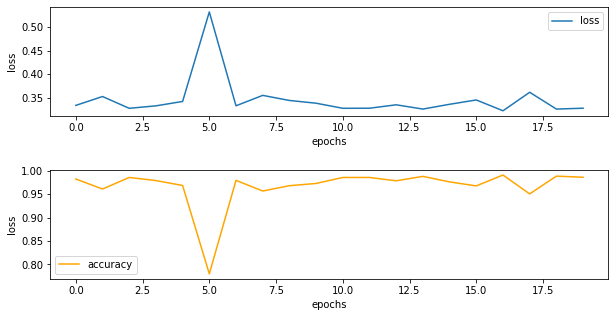

In [6]:
print("result")
print()

fig=plt.figure(figsize=(10,5))

plt.subplots_adjust(wspace=0.2,hspace=0.5)

ax1=fig.add_subplot(2,1,1)
plt.plot(range(len(valid_loss_history)),valid_loss_history)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss'])

ax2=fig.add_subplot(2,1,2)
plt.plot(range(len(valid_accuracy_history)),valid_accuracy_history,'orange')
plt.xlabel('epochs')
plt.ylabel('loss')
ax2.legend(['accuracy'])

print(valid_loss_history)
print(valid_accuracy_history)

In [7]:
for xb,yb in dl_valid_fullsize:
    print(xb.shape)
    print(yb.shape)

torch.Size([2106, 70])
torch.Size([2106])
